# 제조 현장 데이터 분석 및 불량 탐지 실습

- **실습 A**: 지도학습 기반 불량품 탐지 (MLP Classifier)
- **실습 B**: 비지도학습 기반 장비 패턴 분석 (Clustering)


---
---
## 필수 라이브러리 Import

데이터 분석 및 머신러닝에 필요한 라이브러리 임포트

In [ ]:
# 데이터 처리 및 분석 라이브러리
import pandas as pd  # 데이터프레임을 이용한 데이터 조작
import numpy as np   # 수치 연산 및 배열 처리

# 데이터 전처리 라이브러리
from sklearn.impute import KNNImputer  # K-최근접 이웃 알고리즘을 사용한 결측치 대체
from sklearn.preprocessing import StandardScaler  # 데이터 정규화 (평균=0, 표준편차=1)
from sklearn.model_selection import train_test_split # 학습용/검증용 데이터셋 분할

# 머신러닝 모델
from sklearn.neural_network import MLPClassifier  # 다층 퍼셉트론 분류기 (신경망)
from sklearn.cluster import KMeans  # K-Means 클러스터링

# 차원 축소
from sklearn.decomposition import KernelPCA  # 주성분 분석
from sklearn.manifold import TSNE  # t-SNE 차원 축소

# 모델 평가 지표
from sklearn.metrics import (
    accuracy_score,   # 정확도: 전체 중 올바르게 예측한 비율
    f1_score,         # F1 점수: 정밀도와 재현율의 조화평균
    recall_score,     # 재현율: 실제 양성 중 올바르게 예측한 비율
    precision_score,  # 정밀도: 양성으로 예측한 것 중 실제 양성 비율
    roc_auc_score,    # ROC AUC: 분류 모델의 성능 지표
    confusion_matrix  # 혼동 행렬
)
from tqdm import trange  # 진행 상황 표시 바

# 시각화 라이브러리
import matplotlib.pyplot as plt  # 기본 그래프 생성
import seaborn as sns            # 고급 통계 시각화

# 한글 폰트 설정 (필요시 주석 해제)
# from matplotlib import rc
# rc('font', family='NanumGothic')


---
---
# 실습 A: 지도학습 기반 불량 탐지

## 개요
MLP (Multi-Layer Perceptron) 신경망을 사용하여 제조 공정 데이터로부터 불량품을 분류하는 모델을 학습

### 주요 단계
1. 데이터 수집 및 탐색
2. 데이터 품질 확인
3. Train/Test 분할
4. 결측치 처리 (KNN Imputation)
5. 데이터 정규화 (Standardization)
6. 모델 학습 (MLP Classifier)
7. 예측 수행
8. 성능 평가
9. 혼동 행렬 분석


---
## 1단계: 데이터 수집 및 탐색 (EDA)

제조 공정의 센서 데이터를 불러와 기본 구조를 파악
- `X_train.csv`: 학습용 특성 데이터 (센서 값)
- `y_train.csv`: 학습용 라벨 (정상/불량)
- `X_test.csv`: 테스트용 특성 데이터
- `y_test.csv`: 테스트용 라벨


In [ ]:
# 반도체 공정 센서 데이터 로드
# - Feature 데이터: 센서 측정값 (공정 파라미터)
# - Label 데이터: 불량 여부 (0: 정상, 1: 불량)
df = pd.read_csv('./data/features.csv')  # 독립변수 (X): 센서 데이터
label = pd.read_csv('./data/label.csv')  # 종속변수 (y): 불량 여부

# 데이터 기본 정보 확인
print("Feature data (5 example rows)")
display(df.head(5))  # 상위 5개 행 출력
# print(df.info())    # 데이터 타입 및 결측치 정보
# print(df.describe())  # 기술통계량 (평균, 표준편차, 최소/최대값 등)

print("\nLabel data")
# display(label.head())
print(label.value_counts())  # 클래스 분포 확인 (불량/정상 비율)

Feature data (5 example rows)


,stage1_temp,stage2_temp,stage3_temp,stage4_temp,stage5_temp,stage1_humidity,stage2_humidity,stage3_humidity,stage4_humidity,stage5_humidity,...,stage4_viscosity_deviation,stage4_co2_deviation,stage4_o2_deviation,stage4_n_deviation,stage5_flow_deviation,stage5_density_deviation,stage5_viscosity_deviation,stage5_co2_deviation,stage5_o2_deviation,stage5_n_deviation
0,28.57,30.15,30.71,30.91,31.62,69.08,68.98,70.37,73.67,69.41,...,3.897850,-0.381981,-0.917519,2.905965,NaN,14.642069,NaN,2.249968,NaN,NaN
1,31.74,31.29,30.92,29.52,30.70,68.24,75.97,72.06,69.72,76.11,...,-0.336600,NaN,-4.937284,0.089265,-4.937284,12.361204,NaN,3.381750,5.827666,-0.056206
2,31.25,29.16,31.45,30.74,30.26,67.98,78.42,70.97,67.71,70.73,...,5.108084,5.685728,NaN,0.871249,-0.955908,1.587669,1.665659,-0.052572,-0.597566,-2.745544
3,29.96,29.22,28.39,31.96,31.12,68.60,67.80,70.09,71.88,76.71,...,-2.535448,5.497906,-2.134062,-1.188985,-2.134062,NaN,NaN,3.230979,-0.032255,0.157905
4,30.09,29.58,28.06,30.46,28.84,78.24,67.31,72.63,77.78,74.76,...,-10.559326,7.259878,-0.192612,-1.648626,-0.192612,9.741397,NaN,-0.516248,2.129390,0.020616



Label data
label
0        13561
1         3437
Name: count, dtype: int64


## 2단계: 데이터 품질 확인 - 결측치 분석

결측치 분포를 확인하여 전처리가 필요한 부분을 파악


결측치 개수:


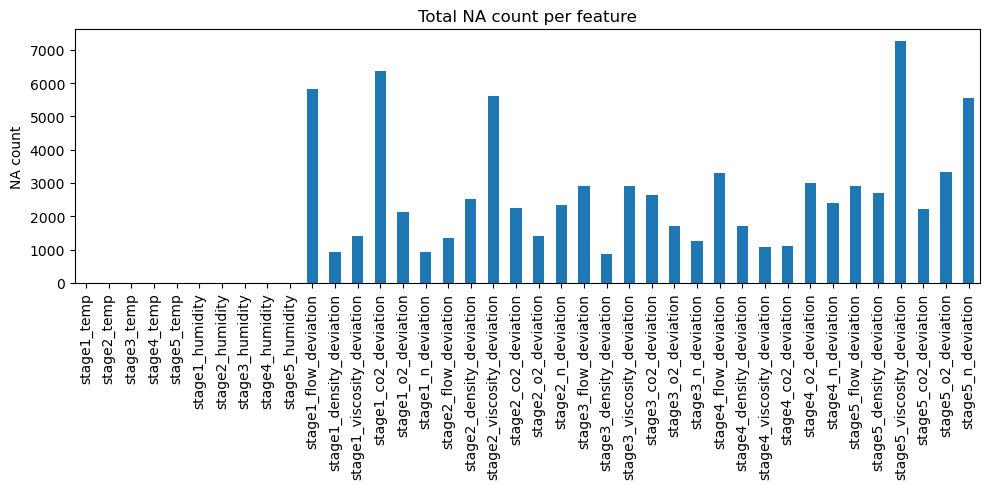

In [5]:
# 각 컬럼별 결측치 확인
# - 결측치는 센서 오류, 통신 문제 등으로 발생 가능
print("결측치 개수:")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
na_series = df.isnull().sum()
na_series.plot(kind='bar', ax=ax)
ax.set_ylabel('NA count')
ax.set_title("Total NA count per feature")
plt.tight_layout()
plt.show()

# print(df.isna().sum())

# # 결측치 비율 계산
# missing_ratio = (df.isna().sum() / len(df)) * 100
# print("\n결측치 비율 (%):")
# print(missing_ratio[missing_ratio > 0])  # 결측치가 있는 컬럼만 출력

## 3단계: Train/Test 데이터 분할

이미 분할된 학습/테스트 데이터의 크기와 클래스 분포를 확인


In [ ]:
# 학습용 데이터와 검증용 데이터 분할
# - test_size=0.2: 전체 데이터의 20%를 검증용으로 사용
# - random_state=42: 재현 가능한 결과를 위한 시드 고정
# - stratify=label: 클래스 비율을 유지하며 분할 (불량/정상 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    df,           # 특성 데이터 (센서 측정값)
    label,        # 레이블 데이터 (불량 여부)
    test_size=0.2,      # 검증 데이터 비율
    random_state=42,    # 난수 시드
    stratify=label,     # 계층적 샘플링
    shuffle=True        # 무작위 추출
)

# 분할 결과 확인
print(f"학습 데이터 크기: {X_train.shape}")
print(f"검증 데이터 크기: {X_test.shape}")
print(f"\n학습 데이터 레이블 분포:\n{y_train.value_counts()}")
print(f"\n검증 데이터 레이블 분포:\n{y_test.value_counts()}")

학습 데이터 크기: (13598, 40)
검증 데이터 크기: (3400, 40)

학습 데이터 레이블 분포:
label
0        10848
1         2750
Name: count, dtype: int64

검증 데이터 레이블 분포:
label
0        2713
1         687
Name: count, dtype: int64


## 4단계: 결측치 처리 - KNN Imputation

K-최근접 이웃 알고리즘을 사용하여 결측치를 대체합니다.
- 주변 5개 샘플의 평균값으로 결측치를 채웁니다.
- 센서 간 상관관계를 고려한 정교한 결측치 처리 방법입니다.


In [8]:
# KNN Imputer를 사용한 결측치 대체
# - K-최근접 이웃(KNN) 알고리즘 활용
# - n_neighbors=5: 가장 가까운 5개 샘플의 평균값으로 대체
# - 장점: 단순 평균/중앙값보다 데이터 패턴을 더 잘 반영
imputer = KNNImputer(n_neighbors=5)

# 학습 데이터로 imputer를 학습하고 결측치 대체
X_train_imputed = imputer.fit_transform(X_train)

# 검증 데이터의 결측치 대체 (학습된 imputer 사용)
# 주의: fit_transform이 아닌 transform 사용 (데이터 누수 방지)
X_test_imputed = imputer.transform(X_test)

# numpy 배열을 다시 DataFrame으로 변환 (컬럼명 유지)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# 결측치 처리 결과 확인
print("결측치 처리 후:")
print(f"학습 데이터 결측치: {X_train_imputed.isna().sum().sum()}")
print(f"검증 데이터 결측치: {X_test_imputed.isna().sum().sum()}")

결측치 처리 후:
학습 데이터 결측치: 0
검증 데이터 결측치: 0


## 5단계: 데이터 정규화 (Normalization)

특성별 스케일 차이를 제거하여 모델 학습을 안정화
- 평균 = 0, 표준편차 = 1로 변환
- 신경망 학습 시 필수적인 전처리 과정


In [11]:
# StandardScaler를 사용한 데이터 정규화
# - 각 특성을 평균=0, 표준편차=1로 변환
# - 수식: (X - 평균) / 표준편차
# - 필요성: 신경망 모델은 스케일에 민감하므로 정규화 필수
scaler = StandardScaler()

# 학습 데이터로 스케일러를 학습하고 변환
X_train_scaled = scaler.fit_transform(X_train_imputed)

# 검증 데이터를 동일한 기준으로 변환
# 주의: 학습 데이터의 평균/표준편차 사용 (데이터 누수 방지)
X_test_scaled = scaler.transform(X_test_imputed)

# 정규화 결과 확인
print("정규화 완료")
print(f"학습 데이터 shape: {X_train_scaled.shape}")
print(f"검증 데이터 shape: {X_test_scaled.shape}")

정규화 완료
학습 데이터 shape: (13598, 40)
검증 데이터 shape: (3400, 40)


## 6단계: 모델 선택 및 학습

다층 퍼셉트론(MLP) 신경망을 학습

### 모델 구조
- 입력층: 특성 개수만큼
- 은닉층: [64, 32] 뉴런 (2개 층)
- 출력층: 2개 클래스 (정상/불량)
- 활성화 함수: ReLU
- 최적화 알고리즘: Adam
- 최대 학습 횟수: 1000 epochs


In [12]:
# ============================================================
# 6단계: 모델 선택 및 학습 - MLP Classifier
# ============================================================

# Multi-Layer Perceptron (다층 퍼셉트론) 분류 모델 정의
# - hidden_layer_sizes=(64, 32): 은닉층 2개 (64개, 32개 뉴런)
# - activation='relu': ReLU 활성화 함수 사용
# - solver='adam': Adam 최적화 알고리즘
# - max_iter=500: 최대 500번 반복 학습
# - random_state=42: 재현 가능성을 위한 시드
model = MLPClassifier(
    hidden_layer_sizes=(64, 32),    # 신경망 구조: 입력층 -> 64 -> 32 -> 출력층
    activation='relu',              # 비선형 활성화 함수
    solver='adam',                  # 경사 하강법 최적화 기법
    max_iter=1000,                  # 학습 반복 횟수
    early_stopping=True,            # 과적합 방지
    learning_rate='adaptive',       # 학습률 조절
    random_state=42,                # 난수 시드
    verbose=True                    # 학습 과정 출력
)

# 모델 학습
# - X_train_scaled: 정규화된 학습 데이터
# - y_train: 학습 데이터의 레이블
print("모델 학습 시작...")
model.fit(X_train_scaled, y_train.values.ravel())
print("\n모델 학습 완료!")

모델 학습 시작...
Iteration 1, loss = 0.52178746
Validation score: 0.836765
Iteration 2, loss = 0.33132147
Validation score: 0.879412
Iteration 3, loss = 0.26281063
Validation score: 0.901471
Iteration 4, loss = 0.22347717
Validation score: 0.911029
Iteration 5, loss = 0.19329002
Validation score: 0.925000
Iteration 6, loss = 0.17154582
Validation score: 0.935294
Iteration 7, loss = 0.15396652
Validation score: 0.941176
Iteration 8, loss = 0.14167980
Validation score: 0.945588
Iteration 9, loss = 0.13224114
Validation score: 0.945588
Iteration 10, loss = 0.12483661
Validation score: 0.954412
Iteration 11, loss = 0.11716431
Validation score: 0.952941
Iteration 12, loss = 0.11117749
Validation score: 0.953676
Iteration 13, loss = 0.10715490
Validation score: 0.958088
Iteration 14, loss = 0.10223870
Validation score: 0.956618
Iteration 15, loss = 0.09932107
Validation score: 0.958824
Iteration 16, loss = 0.09511224
Validation score: 0.955147
Iteration 17, loss = 0.09209295
Validation score: 0.9

## 7단계: 모델 예측

학습된 모델로 테스트 데이터에 대한 예측을 수행


In [15]:
# ============================================================
# 7단계: 모델 예측
# ============================================================

# 학습된 모델로 검증 데이터 예측
y_pred = model.predict(X_test_scaled)

# 예측 확률값도 함께 확인 (분류 신뢰도)
y_pred_proba = model.predict_proba(X_test_scaled)

# 예측 결과 샘플 확인
print("예측 결과 샘플 (처음 5개):")
print(f"실제값: {y_test.values.ravel()[:5]}")
print(f"예측값: {y_pred[:10]}")
print(f"\n예측 확률 (처음 5개):")
print(y_pred_proba[:5])

예측 결과 샘플 (처음 5개):
실제값: [0 0 0 1 0]
예측값: [0 0 0 1 0 0 1 0 0 0]

예측 확률 (처음 5개):
[[9.96401101e-01 3.59889875e-03]
 [9.99960040e-01 3.99596395e-05]
 [9.93758306e-01 6.24169369e-03]
 [4.74376168e-01 5.25623832e-01]
 [9.99992622e-01 7.37844170e-06]]


## 8단계: 모델 성능 평가

다양한 지표로 모델의 성능을 평가

### 평가 지표
- **Accuracy (정확도)**: 전체 중 올바르게 예측한 비율
- **Precision (정밀도)**: 불량으로 예측한 것 중 실제 불량의 비율
- **Recall (재현율)**: 실제 불량 중 올바르게 탐지한 비율
- **F1 Score**: 정밀도와 재현율의 조화평균
- **ROC AUC**: 모델의 전반적인 분류 성능


In [14]:
# 다양한 평가 지표로 모델 성능 측정

# 1. Accuracy (정확도) - 전체 예측 중 올바른 예측의 비율
# - (TP + TN) / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test, y_pred)

# 2. Precision (정밀도) - 불량으로 예측한 것 중 실제 불량의 비율
# - TP / (TP + FP)
# - 거짓 양성(False Positive)을 줄이고자 할 때 중요
precision = precision_score(y_test, y_pred)

# 3. Recall (재현율, 민감도) - 실제 불량 중 올바르게 예측한 비율
# - TP / (TP + FN)
# - 거짓 음성(False Negative)을 줄이고자 할 때 중요
recall = recall_score(y_test, y_pred)

# 4. F1-Score - Precision과 Recall의 조화평균
# - 2 * (Precision * Recall) / (Precision + Recall)
# - 불균형 데이터셋에서 유용
f1 = f1_score(y_test, y_pred)

# 5. ROC-AUC Score - ROC 곡선 아래 면적
# - 0.5~1.0 범위 (1.0에 가까울수록 좋음)
# - 클래스 불균형에 덜 민감
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

# 평가 결과 출력
print("=" * 50)
print("모델 성능 평가 결과")
print("=" * 50)
print(f"Accuracy (정확도):  {accuracy:.4f}")
print(f"Precision (정밀도): {precision:.4f}")
print(f"Recall (재현율):    {recall:.4f}")
print(f"F1-Score:           {f1:.4f}")
print(f"ROC-AUC Score:      {roc_auc:.4f}")
print("=" * 50)

# 해석 가이드
print("\n[평가 지표 해석]")
print("- Accuracy: 전체적인 정확도")
print("- Precision: 불량 판정의 정확성 (오검출 최소화)")
print("- Recall: 실제 불량의 검출률 (미검출 최소화)")
print("- F1-Score: Precision과 Recall의 균형")
print("- ROC-AUC: 전반적인 분류 성능 (1에 가까울수록 우수)")

모델 성능 평가 결과
Accuracy (정확도):  0.9535
Precision (정밀도): 0.9152
Recall (재현율):    0.8486
F1-Score:           0.8807
ROC-AUC Score:      0.9723

[평가 지표 해석]
- Accuracy: 전체적인 정확도
- Precision: 불량 판정의 정확성 (오검출 최소화)
- Recall: 실제 불량의 검출률 (미검출 최소화)
- F1-Score: Precision과 Recall의 균형
- ROC-AUC: 전반적인 분류 성능 (1에 가까울수록 우수)


## 9단계: 혼동 행렬 (Confusion Matrix)

예측 결과를 시각화하여 오류 유형 분석

### 혼동 행렬 해석
- **True Positive (TP)**: 불량을 불량으로 정확히 예측
- **True Negative (TN)**: 정상을 정상으로 정확히 예측
- **False Positive (FP)**: 정상을 불량으로 잘못 예측 (Type I Error)
- **False Negative (FN)**: 불량을 정상으로 잘못 예측 (Type II Error)


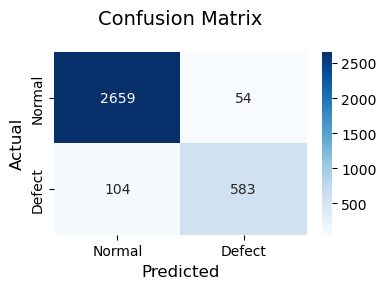


혼동 행렬 분석:
True Negative (TN): 2659개 - 정상을 정상으로 올바르게 예측
False Positive (FP): 54개 - 정상을 불량으로 잘못 예측 (제1종 오류)
False Negative (FN): 104개 - 불량을 정상으로 잘못 예측 (제2종 오류)
True Positive (TP): 583개 - 불량을 불량으로 올바르게 예측


In [16]:
# 혼동 행렬 계산 - 행: 실제 값 (Actual), 열: 예측 값 (Predicted)
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Defect'],
            yticklabels=['Normal', 'Defect'])
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# 혼동 행렬 수치 출력
print("\n혼동 행렬 분석:")
print(f"True Negative (TN): {cm[0, 0]}개 - 정상을 정상으로 올바르게 예측")
print(f"False Positive (FP): {cm[0, 1]}개 - 정상을 불량으로 잘못 예측 (제1종 오류)")
print(f"False Negative (FN): {cm[1, 0]}개 - 불량을 정상으로 잘못 예측 (제2종 오류)")
print(f"True Positive (TP): {cm[1, 1]}개 - 불량을 불량으로 올바르게 예측")

---
---
# 실습 B: 비지도학습 기반 이상 패턴 분석

## 개요
이상 징후를 탐지를 위해 클러스터링과 차원 축소 기법을 활용하여 정상 데이터의 패턴을 학습

### 주요 단계
1. 전체 데이터 로드 및 기본 시각화
2. K-Means 클러스터링으로 정상 패턴 학습 및 문제점 확인
3. 특성 간 상관관계 행렬 계산
4. 윈도우 기반 상관관계 패턴 추출
5. 상관관계 패턴 시각화 및 분석

### 핵심 아이디어
- **라벨 없이** 정상 작동 패턴을 학습
- 센서 간의 **상관관계 패턴**이 정상 상태를 나타냄
- 새로운 데이터가 이 패턴에서 벗어나면 이상 징후로 판단


## 1단계: 전체 데이터 전처리

전체 센서 데이터 전처리


In [106]:
# 비지도 학습을 위해 전체 데이터에 대해 전처리 수행
X_imputed = imputer.transform(df)  # 실습 A에서 학습한 imputer로 결측치 대체
X_scaled = scaler.transform(pd.DataFrame(X_imputed, columns=df.columns))  # 실습 A에서 학습한 scaler로 정규화

## 2단계: K-Means 클러스터링

원본 센서 값을 클러스터링

### K-Means 클러스터링
- 데이터를 K개의 그룹으로 구분
- 각 그룹은 유사한 센서 값 패턴을 가진 샘플들의 집합
- 이 단계에서는 원본 센서 값만 사용
- 문제점 확인


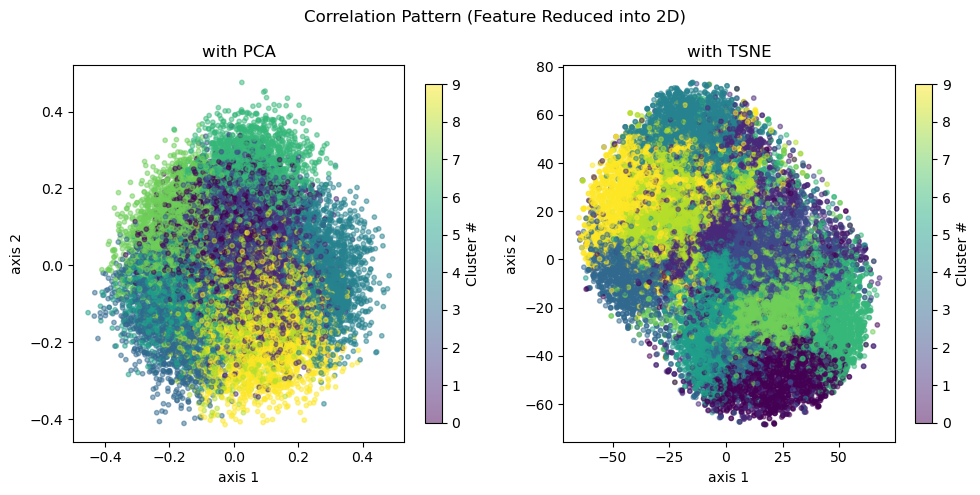

In [107]:
# K-Means 클러스터링 시도
# - 전체 센서 데이터를 10개 그룹으로 분류
# - 비슷한 센서 패턴을 가진 데이터끼리 묶기
km = KMeans(n_clusters=10, random_state=0)
labels = km.fit_predict(pd.DataFrame(X_scaled, columns=df.columns))

# 고차원 데이터를 2차원으로 축소하여 시각화
fig, axes = plt.subplots(1,2,figsize=(10,5))
reducers = {
    'PCA': KernelPCA(n_components=2, kernel='rbf'),     # 주성분 분석 (비선형 방법)
    'TSNE': TSNE(n_components=2)                        # t-SNE (비선형 방법)
}
axes = axes.flatten()
sct = None

for i, (reducer_name, reducer) in enumerate(reducers.items()):
    # 센서 데이터를 2D로 압축
    X_2d = reducer.fit_transform(X_scaled)  # (데이터 수, 2)
    
    # 클러스터별로 색깔을 다르게 하여 산점도 그리기
    sct = axes[i].scatter(X_2d[:, 0], X_2d[:, 1], cmap="viridis", c=labels, s=10, alpha=0.5)
    axes[i].set_xlabel("axis 1")
    axes[i].set_ylabel("axis 2")
    axes[i].set_title(f"with {reducer_name}")
    plt.colorbar(sct, ax=axes[i], shrink=0.9, label="Cluster #")

plt.suptitle("Correlation Pattern (Feature Reduced into 2D)")
plt.tight_layout()
plt.show()

## 3단계: 특성 간 상관관계 행렬 계산

센서들 간의 상관관계를 계산하여 어떤 센서 값들이 함께 움직이는지 파악

### 상관관계란?
- 두 센서 값의 관계를 나타냄
- 스피어만 상관계수는 두 변수 간의 순위를 기반으로 단조 관계의 강도를 측정
- 값의 범위: -1 (완전 음의 상관) ~ +1 (완전 양의 상관)
- 정상 작동 시 특정 상관관계 패턴이 유지됨


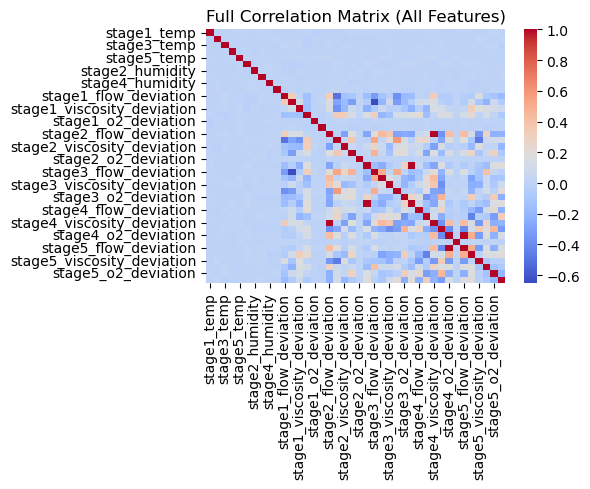


[해석]
- 빨간색: 양의 상관관계 (한 센서 증가 → 다른 센서 증가)
- 파란색: 음의 상관관계 (한 센서 증가 → 다른 센서 감소)
- 흰색: 상관관계 없음


In [108]:
# 전체 센서 간 상관관계 계산 및 시각화
full_corr = df.corr('spearman')  # 스피어만 상관계수 행렬 (-1 ~ 1)
plt.figure(figsize=(6, 5))
sns.heatmap(full_corr, annot=False, cmap='coolwarm')
plt.title("Full Correlation Matrix (All Features)", fontsize=12)
plt.tight_layout()
plt.show()

print("\n[해석]")
print("- 빨간색: 양의 상관관계 (한 센서 증가 → 다른 센서 증가)")
print("- 파란색: 음의 상관관계 (한 센서 증가 → 다른 센서 감소)")
print("- 흰색: 상관관계 없음")

## 4단계: 윈도우 기반 상관관계 패턴 추출

자주 관측되는 상관관계 패턴을 포착 (이상 발생 시 상관관계 패턴이 변화함)

### 배치 단위
- 일정 구간의 데이터로 상관관계 계산
- 랜덤한 위치의 윈도우에서 데이터 선택
- 각 윈도우마다 센서 간 상관관계 벡터를 생성

### 결과
- 원본 값보다 **파생 변수(센서 간 관계 패턴)**가 더 중요한 특성이 될 수 있음



In [109]:
def corr_vector(X, corr_type='spearman'):
    """
    상관관계 상삼각 행렬을 1차원 벡터로 변환
    """
    corr = pd.DataFrame(X).corr(corr_type).values  # 상관관계 행렬
    idx = np.triu_indices_from(corr, k=1)  # 상삼각 인덱스 (k=1: 대각선 제외)
    return corr[idx]  # 필요한 부분만 추출


def make_corr_vectors_from_random_batches(X, window_size=100, num_batches=10000, seed=42):
    """
    전체 데이터에서 랜덤하게 윈도우를 뽑아 상관관계 벡터 생성
    
    Parameters:
    -----------
    X: 전체 센서 데이터
    window_size: 하나의 윈도우 크기 (몇 개 샘플을 묶을지)
    num_batches: 총 몇 개의 윈도우를 만들지
    seed: 랜덤 시드 (같은 결과 재현하기 위해)
    
    Returns:
    --------
    (num_batches × 상관관계 개수) 크기의 행렬
    - 각 행 = 하나의 윈도우에서 추출한 상관관계 패턴
    """
    np.random.seed(seed)
    N = len(X)
    vecs = []

    for _ in range(num_batches):
        # 데이터에서 랜덤하게 시작점 선택
        start = np.random.randint(0, N - window_size)
        end = start + window_size
        X_win = X[start:end]  # 윈도우 추출
        vecs.append(corr_vector(X_win))  # 해당 윈도우의 상관관계 벡터 계산

    return np.array(vecs)

# 실제 상관관계 벡터 생성
# - 200개 샘플을 하나의 윈도우로 간주
# - 20,000개의 윈도우 생성
X_corr = make_corr_vectors_from_random_batches(X_scaled, window_size=200, num_batches=20000)

# 상관관계 패턴을 기반으로 클러스터링
# - 비슷한 상관관계 패턴을 가진 윈도우끼리 묶음
# - 각 클러스터 = 하나의 "정상 작동 모드"
km = KMeans(n_clusters=10, random_state=0)
labels = km.fit_predict(X_corr)

print(f"상관관계 데이터 shape: {X_corr.shape}")
print(f"  - 윈도우 개수: {X_corr.shape[0]}")
print(f"  - 상관관계 특성 수: {X_corr.shape[1]}")
print(f"클러스터링 완료: {len(np.unique(labels))}개 클러스터")

상관관계 데이터 shape: (20000, 780)
  - 윈도우 개수: 20000
  - 상관관계 특성 수: 780
클러스터링 완료: 10개 클러스터


## 5단계: 상관관계 패턴 시각화

상관관계 벡터를 2차원으로 축소하여 시각화

### 차원 축소 기법
- **PCA (Principal Component Analysis)**: 전역 구조 파악에 유리
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: 국소 클러스터 구조 파악에 유리

### 시각화 해석
- 같은 색상의 점들: 유사한 센서 상관관계 패턴
- 클러스터 간 거리: 패턴 차이의 크기
- 명확한 클러스터 분리: 정상 작동 모드가 잘 구분됨

### 실무 활용
- 새로운 데이터의 상관관계 패턴이 기존 클러스터에서 멀리 떨어지면 → 이상 징후
- 라벨 없이도 정상 패턴을 학습하여 이상 탐지 가능


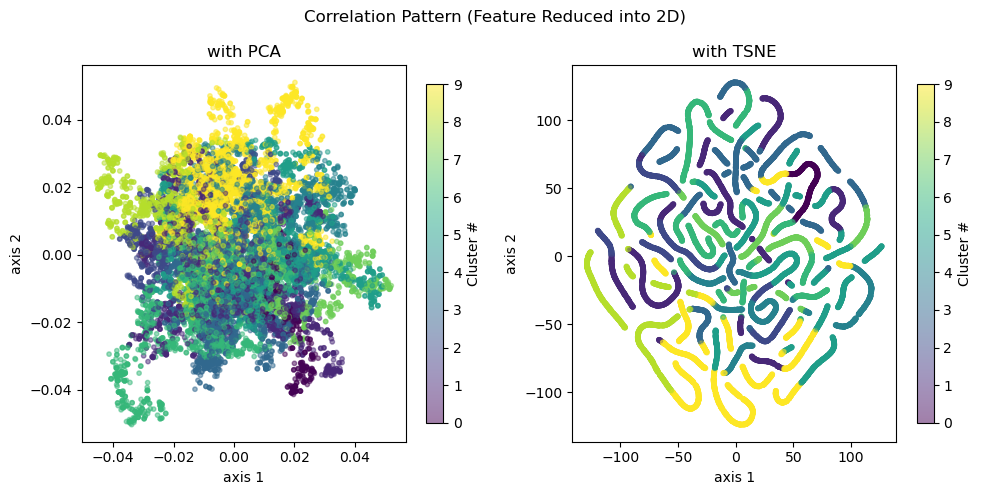


[결과 비교]
- 2단계보다 클러스터 분리가 더 명확함
- 각 클러스터 = 센서 간 관계가 유사한 정상 작동 모드
- 활용: 새로운 데이터가 이 패턴에서 벗어나면: 기기 이상 징후

[시각화 해석]
- 같은 색상의 점들은 유사한 센서 상관관계 패턴을 가짐
- 클러스터 간 거리가 멀수록 패턴 차이가 큼
- PCA: 전역 구조 파악에 유리
- t-SNE: 국소 클러스터 구조 파악에 유리

[핵심 포인트]
- 원본 센서 값보다 '센서 간 관계 패턴'이 더 의미 있는 특성
- 정상 패턴을 학습: 비정상 탐지에 활용 가능


In [110]:
# 센서 값 상관관계 벡터를 2D로 축소하여 시각화

reducers = {
    'PCA': KernelPCA(n_components=2, kernel='rbf'),     # 주성분 분석
    'TSNE': TSNE(n_components=2)                        # t-SNE
}

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
sct = None
for i, (reducer_name, reducer) in enumerate(reducers.items()):
    # 상관관계 패턴을 2D로 압축
    X_2d = reducer.fit_transform(X_corr)
    
    # 클러스터별로 색깔을 다르게 하여 산점도 그리기
    sct = axes[i].scatter(X_2d[:, 0], X_2d[:, 1], cmap="viridis", c=labels, s=10, alpha=0.5)
    axes[i].set_xlabel("axis 1")
    axes[i].set_ylabel("axis 2")
    axes[i].set_title(f"with {reducer_name}")
    plt.colorbar(sct, ax=axes[i], shrink=0.9, label="Cluster #")

plt.suptitle("Correlation Pattern (Feature Reduced into 2D)")
plt.tight_layout()
plt.show()

print("\n[결과 비교]")
print("- 2단계보다 클러스터 분리가 더 명확함")
print("- 각 클러스터 = 센서 간 관계가 유사한 정상 작동 모드")
print("- 활용: 새로운 데이터가 이 패턴에서 벗어나면: 기기 이상 징후")

print("\n[시각화 해석]")
print("- 같은 색상의 점들은 유사한 센서 상관관계 패턴을 가짐")
print("- 클러스터 간 거리가 멀수록 패턴 차이가 큼")
print("- PCA: 전역 구조 파악에 유리")
print("- t-SNE: 국소 클러스터 구조 파악에 유리")

print("\n[핵심 포인트]")
print("- 원본 센서 값보다 '센서 간 관계 패턴'이 더 의미 있는 특성")
print("- 정상 패턴을 학습: 비정상 탐지에 활용 가능")

---
## 실습 요약

### 실습 A - 지도학습 (MLP Classifier)
- **목적**: 라벨이 있는 데이터로 불량품 분류 모델 학습
- **장점**: 높은 정확도, 명확한 성능 지표
- **단점**: 라벨링 작업 필요, 새로운 불량 유형 탐지 어려움

### 실습 B - 비지도학습 (Clustering)
- **목적**: 라벨 없이 정상 패턴 학습 및 이상 탐지
- **장점**: 라벨 불필요, 새로운 이상 패턴 탐지 가능
- **단점**: 성능 평가 어려움, 임계값 설정 필요